In [1]:
import sys 
sys.path.append('/home/goetzl/ETH/NeuralPlanes')

In [2]:
print(sys.path)
from NeuralPlanes.localization.map import NeuralMap, NeuralMapConf, normalize_features
from NeuralPlanes.localization.pose_scoring import score_pose
from NeuralPlanes.localization.unet import Unet
from NeuralPlanes.pipeline.lamar import *
from NeuralPlanes.pipeline.dataloader import *
from NeuralPlanes.plane import Planes 
from NeuralPlanes.utils import select_device
from NeuralPlanes.camera import compute_ray
from matplotlib import pyplot as plt 
import copy
import umap

['/home/goetzl/ETH/NeuralPlanes/NeuralPlanes/pipeline', '/home/goetzl/ETH/NeuralPlanes/NeuralPlanes/pipeline/$PYTHONPATH', '/home/goetzl/ETH/NeuralPlanes/NeuralPlanes/pipeline/~/ETH/NeuralPlanes', '/home/goetzl/miniconda3/envs/robo_ml_wsl/lib/python311.zip', '/home/goetzl/miniconda3/envs/robo_ml_wsl/lib/python3.11', '/home/goetzl/miniconda3/envs/robo_ml_wsl/lib/python3.11/lib-dynload', '', '/home/goetzl/miniconda3/envs/robo_ml_wsl/lib/python3.11/site-packages', '/home/goetzl/miniconda3/envs/robo_ml_wsl/lib/python3.11/site-packages/tinycudann-1.7-py3.11-linux-x86_64.egg', '/home/goetzl/ETH/NeuralPlanes']


In [3]:
device = select_device()

In [3]:
lamar_path = Path("../../data/HGE/HGE")
max_size = 256

session_map_path = lamar_path / "sessions" / "map"
session_map_image_path = session_map_path / "raw_data"
session_map_path_precompute = lamar_path / "sessions" / ("map_precompute_"+str(max_size))
session_map_path_depth = session_map_path_precompute / "depth"
session_map_path_small = session_map_path_precompute / "small_images"

images_raw = parse_session(session_map_path, lambda path: path.startswith("ios"))
cameras, images_small, images_depth = get_preprocessed_images(images_raw, session_map_path_small, session_map_path_depth, max_size)

print("Map images ", len(images_raw))

floor_plan_img, plane_points, floorplan_to_world = parse_floorplan(lamar_path / "floor_plan")

100%|██████████| 7553/7553 [00:01<00:00, 3827.18it/s]


Map images  7553
flip
flip
flip
flip


/home/goetzl/ETH/NeuralPlanes/NeuralPlanes/pipeline/lamar.py:303: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at ../aten/src/ATen/native/Cross.cpp:62.)
  normal = torch.cross(x1-x0, x2-x1)


flip
flip
flip
flip


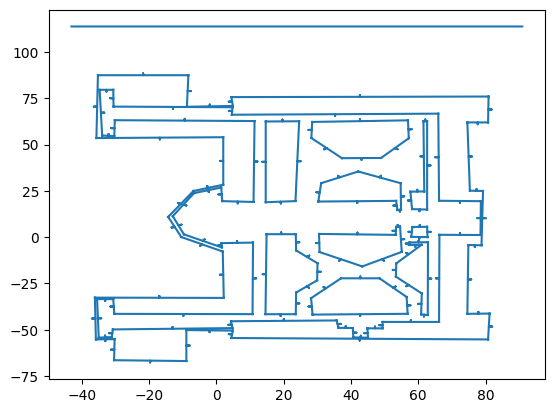

In [4]:
floor_plan_img, plane_points, floorplan_to_world = parse_floorplan(lamar_path / "floor_plan")

fig, ax = plt.subplots()
plot_floor_planes(fig, ax, plane_points)

In [6]:
image = images_raw[600]
model = MonocularDepthModel()
model = model.to(device)

data = collate_fn(compose([model.preprocess]))([image])

data = {k: v.to(device) if isinstance(v,torch.Tensor) else v for k,v in data.items()}

result = model(data)
depth = result["image"][0].detach().cpu().numpy()
print(depth.shape)

fig, axs = plt.subplots(1,2)
axs[0].imshow(data["rgb"][0].detach().cpu().permute(1,2,0))
axs[1].imshow(depth)


Using cache found in /home/goetzl/.cache/torch/hub/yvanyin_metric3d_main
xFormers not available
xFormers not available
xFormers not available
xFormers not available


KeyboardInterrupt: 

In [ ]:
model_checkpoint = "checkpoint/model.pt"

conf = NeuralMapConf(num_components=4, num_features_backbone=21, num_features=8, depth_sigma=0.2)
encoder = Unet(encoder_freeze=True, classes= conf.num_features+1)

height, width =  1736, 845
n_planes = 73
n_comp = conf.num_components
n_feat = conf.num_features
map = NeuralMap(planes=Planes(x0s=torch.zeros((n_planes,3)),
                                us=torch.zeros((n_planes,3)), 
                                vs=torch.zeros((n_planes,3)), 
                                planes=torch.zeros((n_planes,4)), 
                                coord_x0=torch.zeros((n_planes,2)), 
                                coord_size=torch.zeros((n_planes,2)), 
                                atlas_size=[width, height]), 
                    atlas_alpha=torch.zeros((n_comp,height,width), device=device), 
                    atlas_mu=torch.zeros((n_comp, n_feat, height, width),device=device), 
                    atlas_var=torch.zeros((n_comp, n_feat, height, width),device=device), 
                    atlas_weight=torch.zeros((height, width),device=device), encoder=encoder, conf=conf)
map.load_state_dict(torch.load(model_checkpoint), strict=False)
encoder = encoder.to(device)

/home/goetzl/miniconda3/envs/robo_ml_wsl/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/goetzl/miniconda3/envs/robo_ml_wsl/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


upsample_blocks[0] in: 2048   out: 256
upsample_blocks[1] in: 256   out: 128
upsample_blocks[2] in: 128   out: 64
upsample_blocks[3] in: 64   out: 32
upsample_blocks[4] in: 32   out: 16


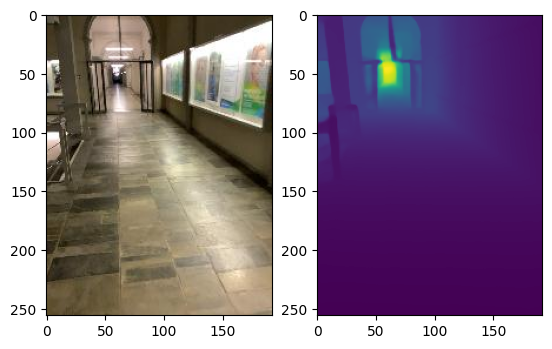

In [ ]:
image_id = 1300
fig, ax = plt.subplots(1,2)
ax[0].imshow(images_small[image_id]['image'])
ax[1].imshow(images_depth[image_id]['image'])

In [ ]:
image = images_small[image_id]
image_torch = encoder.preprocess(image)["image"]
depth = images_depth[image_id]["image"][:,:,0]
depth_torch = torch.tensor(depth, dtype=torch.float, device=device)

print(image_torch.shape)
features = map.encoder({"image": image_torch[None].to(device) })["image"]
features = normalize_features(conf, features)[0]

weight, rem_features = features[0,:,:], features[1:,:,:]
print(weight.min(), weight.max(), rem_features.min(), rem_features.max())


torch.Size([3, 256, 192])
tensor(0.7415, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.9179, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-0.9637, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6412, device='cuda:0', grad_fn=<MaxBackward1>)


In [ ]:
feat_np = rem_features.permute(1,2,0).detach().cpu().numpy()
mapper = umap.UMAP(n_components=3).fit(feat_np.reshape(-1,conf.num_features))

/home/goetzl/miniconda3/envs/robo_ml_wsl/lib/python3.11/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 192, 3)


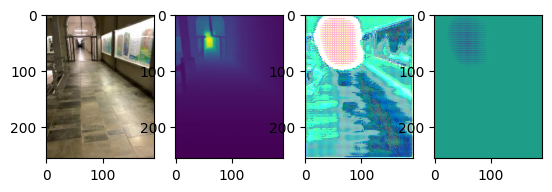

In [ ]:
fig, axes = plt.subplots(1,4)
height,width,c = image["image"].shape 
print((height,width,c))
axes[0].imshow(image["image"])
axes[1].imshow(depth)
axes[2].imshow(mapper.embedding_.reshape(height,width,3))
axes[3].imshow(weight.cpu().detach().numpy())

In [ ]:
print("Image=", rem_features.mean(), "Max depth=", depth.max())

planes = map.planes
x00 = planes.x0s[0] 
x01 = planes.x0s[0] + planes.us[0]
x10 = planes.x0s[0] + planes.vs[0]
x11 = planes.x0s[0] + planes.us[0] + planes.vs[0]

div = 60
div_rot = 1
cam = image["camera"]
xs,ys,thetas = torch.meshgrid(torch.linspace(x00[0], x01[0], div), torch.linspace(x01[1], x11[1], div), torch.linspace(0, 2*torch.pi, div_rot)) 
xs,ys,thetas = xs.flatten(),ys.flatten(),thetas.flatten()

print(cam.size, image["image"].shape)

scores = torch.zeros(len(xs))
weights = torch.zeros(len(xs))

print("Features=", features.shape)

scale_factor = 1.0/4
cam = cam.scale(scale_factor)
feature_small = torch.nn.functional.interpolate(features[None], scale_factor=scale_factor)[0]
depth_small = torch.nn.functional.interpolate(depth_torch[None, None], scale_factor=scale_factor)[0,0]

R_canon, t_canon = cam.R, torch.tensor([0,0,cam.t[2]])

with torch.no_grad():
    for i, (x,y,theta) in enumerate(zip(tqdm.tqdm(xs),ys,thetas)):
        new_cam = copy.copy(cam)
        new_cam.t = t_canon + torch.tensor([x,y,0])
        
        R = torch.tensor([
            [torch.cos(theta), -torch.sin(theta), 0],
            [torch.sin(theta), torch.cos(theta), 0,],
            [0, 0, 1]
        ])
        
        new_cam.R = R @ R_canon @ R.T
        new_cam.t = t_canon + torch.tensor([x,y,0])
        #print(new_cam.size.device,new_cam.R.device, map.planes.x0s.device, features.device, depth_small.device)
        score, weight = score_pose(map, new_cam, feature_small, depth_small)
        #plane_indices=torch.tensor([0])) # plane_indices=torch.tensor([0]))
        scores[i] = score
        weights[i] = weight
    scores = scores.reshape((div,div,div_rot))
    weights = weights.reshape((div,div,div_rot))
    xs = xs.reshape((div,div,div_rot))
    ys = ys.reshape((div,div,div_rot))
    theta = thetas.reshape((div,div,div_rot))

print(scores.mean(), scores.max())

/home/goetzl/miniconda3/envs/robo_ml_wsl/lib/python3.11/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Image= tensor(-0.1223, device='cuda:0', grad_fn=<MeanBackward0>) Max depth= 41.94
tensor([192, 256]) (256, 192, 3)
Features= torch.Size([9, 256, 192])


  0%|          | 0/3600 [00:00<?, ?it/s]/home/goetzl/miniconda3/envs/robo_ml_wsl/lib/python3.11/site-packages/torch/nn/functional.py:4343: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
  9%|▊         | 308/3600 [00:27<05:11, 10.58it/s]

In [ ]:
gt = cam.t
print(gt)

#prob, dense, eval = score_pose(map, cam, feature_small, depth_small, plane_indices=torch.tensor([0]), dense=True)
score, weight = score_pose(map, cam, feature_small, depth_small, plane_indices=torch.tensor([0])) # rel_x0=rel_x0[None], rel_x1=rel_x1[None])
print("score at pos ", score, weight)

final_scores = (weights * scores).max(dim=2)[0] 
print(xs.shape, final_scores.shape)
avg_x = (xs[:,:,0] * final_scores).sum() / final_scores.sum()
avg_y = (ys[:,:,0] * final_scores).sum() / final_scores.sum() 

print(np.linalg.norm(np.array([avg_x,avg_y]) - np.array([gt[0],gt[1]])))
#scores = torch.where(weights > 0.4, scores, torch.tensor(0.0))


#plt.imshow(xs[:,:,0], ys[:,:,])

planes = map.planes
points = [] 
for i in range(len(map.planes)):
    x0 = planes.x0s[i]
    x1 = planes.x0s[i] + planes.us[i]
    points.append(x0[:2])
    points.append(x1[:2])
    points.append(torch.tensor([torch.inf,torch.inf]))
points = torch.stack(points)

plt.scatter(xs[:,:,0].flatten(),ys[:,:,0].flatten(), c= final_scores.max(dim=2)[0].flatten()) #, vmin=0.4, vmax=0.8)

o, dir = compute_ray(1,1,cam,'cpu')

p = o[0,0] + 3*dir[0,0]

plt.plot([gt[0].item(), p[0].item()], [gt[1].item(), p[1].item()], color="red")
plt.scatter([avg_x.item()], [avg_y.item()], color="green")

plt.plot(points[:,0], points[:,1])

tensor([16.7547, 14.5627,  1.7477])
score at pos  tensor(0.7308, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.4902, device='cuda:0', grad_fn=<MeanBackward0>)
torch.Size([60, 60, 1]) torch.Size([60, 60])
21.238052


IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

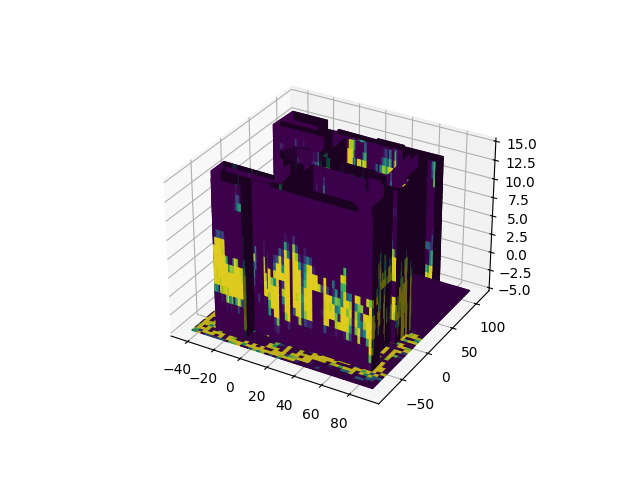

In [ ]:
%matplotlib widget 

from math import ceil

def draw_planes(ax, planes, stride=None, indices=None, color=None):
    if stride is None:
        stride = int(ceil(max(planes.atlas_size) / 512))

    xs = []
    ys = []

    if indices==None:
        indices = range(len(planes))

    xs = []
    for i in indices:
        width, height = planes.coord_size[i]
        v, u = torch.meshgrid(torch.linspace(0,1,int(height)//stride), torch.linspace(0,1,int(width)//stride))

        x0,u_dir,v_dir = planes.x0s[i], planes.us[i], planes.vs[i]

        x = x0.reshape((1,1,3)) + u_dir.reshape((1,1,3))*u.unsqueeze(2) + v_dir.reshape((1,1,3))*v.unsqueeze(2)
        x = x.cpu()

        if not color is None:
            coord = int(planes.coord_x0[i][0]), int(planes.coord_x0[i][1])
            size = int(planes.coord_size[i][0]), int(planes.coord_size[i][1])
            #draw_planes(ax, planes, indices=[i], color= self.map.atlas_weight[coord[1]:coord[1]+size[1], coord[0]:coord[0]+size[0]]

            if len(color.shape) == 2:
                #color = torch.nn.functional.grid_sample(color[None,None], coords[None])[0,0]
                plane_color = color[coord[1]:coord[1]+size[1]:stride, coord[0]:coord[0]+size[0]:stride]
                plane_color = plane_color.clone().detach().cpu()
                plane_color = plt.cm.viridis(plane_color)
            else:
                plane_color = color[coord[1]:coord[1]+size[1]:stride, coord[0]:coord[0]+size[0]:stride]
                plane_color = plane_color.clone().detach().cpu()
                plane_color = plane_color.permute(1,2,0)
        
        ax.plot_surface(x[:,:,0], x[:,:,1], x[:,:,2], facecolors= plane_color)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

draw_planes(ax, map.planes, color= map.atlas_weight) # indices=[0])
#ax.set_aspect('equal')

In [ ]:
map.planes.planes[0][0:3], map.planes.us[0][0:3], map.planes.vs[0][0:3]

(tensor([0., 0., 0.]), tensor([0., 0., 0.]), tensor([0., 0., 0.]))